# Key Processes:
1. **Data Preprocessing & Feature Selection**  
   - Clean, transform, and prepare the dataset for analysis.
   - Identify and select the most relevant features to enhance model performance.

2. **Model Selection & Fine-tuning**  
   - Choose the optimal model architecture.
   - Adjust hyperparameters to maximize model accuracy and robustness.

In [4]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## Step 1. Data preprocessing

In [6]:
# read train and test data into pandas dataframe
df = pd.read_csv('data-train.csv')
df_test = pd.read_csv('data-test.csv')

### Drop columns that not in the test dataset.

In [8]:
# Columns not in the test dataset
columns_not_in_test=[x for x in df.columns if x not in df_test.columns]

columns_to_drop = [x for x in columns_not_in_test if 'is_airout' not in x]

# Drop the columns from the DataFrame
df_cleaned = df.drop(columns=columns_to_drop)
#print(df_cleaned['is_airout'].unique())
print("train dataset shape after dropping columns:", df_cleaned.shape)

train dataset shape after dropping columns: (91553, 17)


In [9]:
df_cleaned.columns

Index(['pitch_id', 'gamedate', 'temperature', 'level', 'bat_side',
       'pitch_side', 'inning', 'top', 'pre_balls', 'pre_strikes', 'pre_outs',
       'venue_id', 'exit_speed', 'hit_spin_rate', 'vert_exit_angle',
       'horz_exit_angle', 'is_airout'],
      dtype='object')

### Majority of the pitches is Fastball in the dataset

In [11]:
df_cleaned['is_airout'].value_counts()

is_airout
0    57495
1    34058
Name: count, dtype: int64

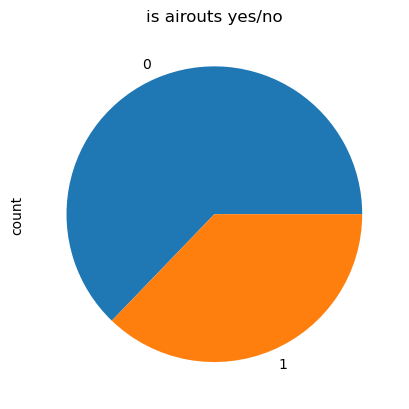

In [12]:
pt_df = df_cleaned['is_airout'].value_counts()
pt_df.plot(kind='pie', title='is airouts yes/no');
plt.savefig('is_airout_counts.png')

### Handling Missing Data

#### For `hit_spin_rate`, remove rows with missing values due to the minimal impact on the dataset.

In [14]:
print(df_cleaned.shape)
df_cleaned = df_cleaned.dropna(subset=['hit_spin_rate'])
print(df_cleaned.shape)

(91553, 17)
(90256, 17)


### Extract Year/Month/Day from gamedate

In [16]:
df_cleaned['gamedate']=pd.to_datetime(df_cleaned['gamedate'])

# Extract year, month, and day
df_cleaned['Year'] = df_cleaned['gamedate'].dt.year
df_cleaned['Month'] = df_cleaned['gamedate'].dt.month
df_cleaned['Day'] = df_cleaned['gamedate'].dt.day

df_cleaned.drop(columns=['gamedate'], inplace=True)


#### Encode unique values in categorical or object-type columns as distinct integers

In [18]:
# Extract only the object-type columns
object_columns = df_cleaned.select_dtypes(include='object')

# Display the extracted columns
print(object_columns.columns)
col_list = list(object_columns.columns)

for c in col_list:
    df_cleaned[c+'_enc'] = pd.factorize(df_cleaned[c])[0]

df_cleaned=df_cleaned.drop(columns=col_list)
df_cleaned.info()

Index(['pitch_id', 'level', 'bat_side', 'pitch_side'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 90256 entries, 0 to 91552
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   temperature      90256 non-null  int64  
 1   inning           90256 non-null  int64  
 2   top              90256 non-null  int64  
 3   pre_balls        90256 non-null  int64  
 4   pre_strikes      90256 non-null  int64  
 5   pre_outs         90256 non-null  int64  
 6   venue_id         90256 non-null  int64  
 7   exit_speed       90256 non-null  float64
 8   hit_spin_rate    90256 non-null  float64
 9   vert_exit_angle  90256 non-null  float64
 10  horz_exit_angle  90256 non-null  float64
 11  is_airout        90256 non-null  int64  
 12  Year             90256 non-null  int32  
 13  Month            90256 non-null  int32  
 14  Day              90256 non-null  int32  
 15  pitch_id_enc     90256 non-null  int64

## Step 2: Feature Selection

### Various techniques can be applied for effective feature selection. Three approaches are demonstrated below.

### Approach 1: Evaluate the correlation between each input feature and the target

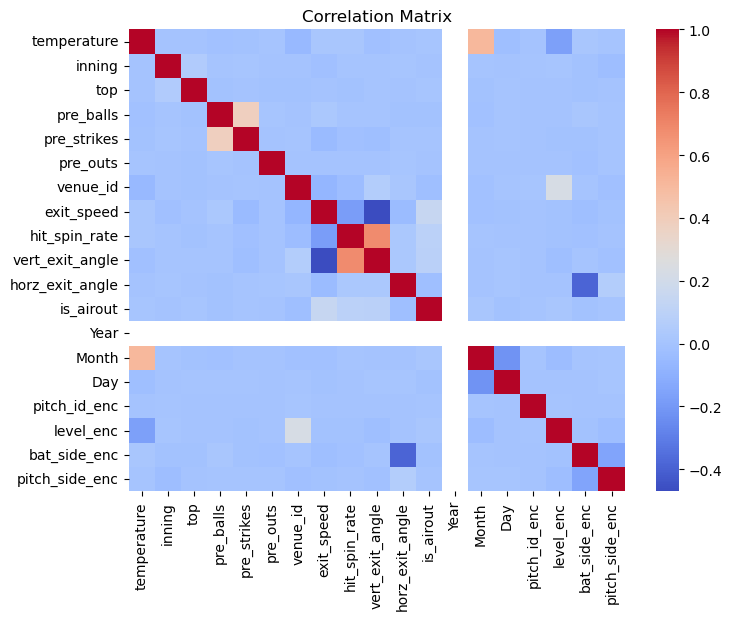

In [21]:
# Step 1: Calculate the correlation matrix
corr_matrix = df_cleaned.corr()

# Step 2: Plot the correlation matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', cbar=True)

# Show the plot
plt.title("Correlation Matrix")
plt.show()


#### One approach is to select features with a high correlation to the target variable, `is_airout`.

'selected features: '

['level_enc',
 'venue_id',
 'horz_exit_angle',
 'vert_exit_angle',
 'hit_spin_rate',
 'exit_speed']

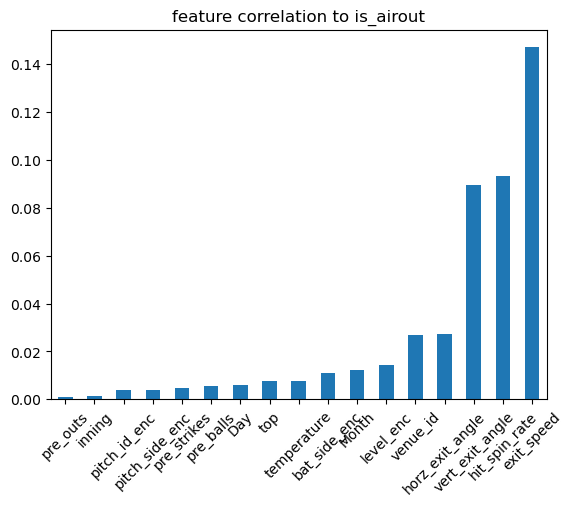

In [29]:
corr_pitch = corr_matrix['is_airout']
corr_pitch.abs().sort_values().iloc[:-2].plot.bar(rot=45, title="feature correlation to is_airout");
select_features = corr_pitch.abs().sort_values().iloc[-8:-2].index
display("selected features: ", list(select_features))

### Approach 2: Apply feature selection models from the `sklearn` library

In [32]:

# Split the data into features (X) and target (y)
X = df_cleaned.drop('is_airout', axis=1)
y = df_cleaned['is_airout']


X_train, y_train = X, y

# Train a RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Use SelectFromModel to select important features
selector = SelectFromModel(rf, max_features=7)  # Select features with importance greater than the mean

# Fit the selector to the training data
selector.fit(X_train, y_train)

# Transform the data to contain only the selected features
X_train_selected = selector.transform(X_train)

# Print the original features
print("Original Features:\n", X.columns)

# Print the selected features
print("\nSelected Features (after SelectFromModel):\n", X.columns[selector.get_support()])


Original Features:
 Index(['temperature', 'inning', 'top', 'pre_balls', 'pre_strikes', 'pre_outs',
       'venue_id', 'exit_speed', 'hit_spin_rate', 'vert_exit_angle',
       'horz_exit_angle', 'Year', 'Month', 'Day', 'pitch_id_enc', 'level_enc',
       'bat_side_enc', 'pitch_side_enc'],
      dtype='object')

Selected Features (after SelectFromModel):
 Index(['exit_speed', 'hit_spin_rate', 'vert_exit_angle', 'horz_exit_angle'], dtype='object')


### Approach 3: Utilize feature importance rankings from a RandomForest model to select the top features

In [34]:
# Split the data into features (X) and target (y)
X = df_cleaned.drop('is_airout', axis=1)
y = df_cleaned['is_airout']


X_train, y_train = X, y

# Train a RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


# Step 4: Extract feature importances from the trained model
importances = rf.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame(columns=['feature_names', 'importance'])
importance_df['feature_names']=feature_names
importance_df['importance']=importances

In [35]:
importance_df.sort_values(by='importance', ascending=False)

,feature_names,importance
10,horz_exit_angle,0.365566
7,exit_speed,0.186078
9,vert_exit_angle,0.145956
8,hit_spin_rate,0.071835
14,pitch_id_enc,0.039405
6,venue_id,0.032082
0,temperature,0.031651
13,Day,0.029327
1,inning,0.021175
12,Month,0.015283


### Note: All three approaches consistently identify the top four features as `exit_speed`, `hit_spin_rate`, `vert_exit_angle`, and `horz_exit_angle`.

## Step 3. Model comparison and selection

## Using top 4 selected features:
 ['horz_exit_angle', 'hit_spin_rate',
       'vert_exit_angle', 'exit_speed']

In [40]:
input_features = [ 'horz_exit_angle', 'hit_spin_rate',
       'vert_exit_angle', 'exit_speed']

df_fea = df_cleaned[input_features+['is_airout']]

### Experiment with various classification algorithms and evaluate their performance by splitting the data into training and testing sets.

In [42]:
df_fea
# Split the data into features (X) and target (y)
X = df_fea.drop(['is_airout'], axis=1)
y = df_fea['is_airout']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
print(X_train.shape)
print(X_test.shape)

(72204, 4)
(18052, 4)


### Model Comparison

Evaluate each classifier model, noting that each has parameters that can be fine-tuned to achieve an optimal balance between overfitting and underfitting.

In [45]:
names = [
    "Logistic Regression", 
    "Nearest Neighbors",
    #"Linear SVM",
    #"RBF SVM",
    #"Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "GradientBoosting",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    LogisticRegression(), 
    KNeighborsClassifier(),
    #SVC(kernel="linear", C=0.025, random_state=42),
    #SVC(gamma=2, C=1, random_state=42),
    #GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(max_iter=5000, random_state=412),
    GradientBoostingClassifier(), 
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

# iterate over classifiers
for name, clf in zip(names, classifiers):
    print("Model: ", name)

    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    score_tr = clf.score(X_train, y_train)
    score_te = clf.score(X_test, y_test)
    print("train score vs. test score: ", score_tr, " ", score_te)


Model:  Logistic Regression
train score vs. test score:  0.6339537975735416   0.634555727897186
Model:  Nearest Neighbors
train score vs. test score:  0.9109329123040275   0.8723133170839796
Model:  Decision Tree
train score vs. test score:  1.0   0.8433968535342344
Model:  Random Forest
train score vs. test score:  0.9999723007035621   0.8843341458010193
Model:  Neural Net
train score vs. test score:  0.8865298321422636   0.8853866607578108
Model:  GradientBoosting
train score vs. test score:  0.8817101545620741   0.8785730113006869
Model:  AdaBoost


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


train score vs. test score:  0.8458949642679076   0.8463882118324839
Model:  Naive Bayes
train score vs. test score:  0.7985845659520249   0.8037336583204077
Model:  QDA
train score vs. test score:  0.7593069636031244   0.7599157988034567


### Top Three Performing Models: Neural Networks, Random Forest, and Gradient Boosting

### If computational resources permit, hyperparameters can be optimized using Grid Search.

In [48]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.7s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.8s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.9s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.6s
[CV] END max_depth=3, min_samples_leaf

### Given the slight imbalance in the dataset, with the majority of data points representing non-airout events, various techniques can be applied to address this imbalance. Below demonstrates one such approach. 

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

clf = make_pipeline(StandardScaler(), rf_clf)
clf.fit(X_resampled, y_resampled)
#rf_clf.fit(X_train, y_train)
score_tr = clf.score(X_train, y_train)
score_te = clf.score(X_test, y_test)
print("train score vs. test score: ", score_tr, " ", score_te)

### Initial results suggest that the neural network may be underfitting. Try using a neural network with two hidden layers (a more complex model) to see if it improves test accuracy.

Note that for neural networks, feature normalization is required. 

In [52]:

names = [

    "Neural Net",

]

classifiers = [
    MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=5000, random_state=412, learning_rate='adaptive', learning_rate_init=0.003),
]

# iterate over classifiers
for name, clf in zip(names, classifiers):
    print("Model: ", name)

    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    score_tr = clf.score(X_train, y_train)
    score_te = clf.score(X_test, y_test)
    print("train score vs. test score: ", score_tr, " ", score_te)


Model:  Neural Net
train score vs. test score:  0.8972217605672816   0.892144914690893


### Ensemble Modeling for Improved Performance

Using an ensemble model can often enhance performance and reduce overfitting. A straightforward approach is majority voting.

- **Note:** To predict the probability of `is_airout`, we apply *soft voting*, which averages the probabilities across models for a more balanced prediction.

### In this case, the ensemble model does not outperform the individual models.

In [54]:
# Step 3: Create base models
LR_clf=  LogisticRegression()
KN_clf=    KNeighborsClassifier()
DT_clf=    DecisionTreeClassifier()
Rf_clf=    RandomForestClassifier()
MLP_clf=    MLPClassifier(max_iter=5000, random_state=42)
GB_clf=    GradientBoostingClassifier()
AB_clf=    AdaBoostClassifier()
NB_clf=    GaussianNB()
QDA_clf=    QuadraticDiscriminantAnalysis()

# Step 4: Combine models using VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('LR', LR_clf),
    ('KN', KN_clf),
    ('DT', DT_clf),
    ('Rf', Rf_clf),
    ('MLP', MLP_clf),
    ('GB', GB_clf),
    ('AB', AB_clf),   
    ('NB', NB_clf),
    ('QDA', QDA_clf)
], voting='soft')  # 'hard' for majority voting, 'soft' for probability-based voting

# Step 5: Train the ensemble model
voting_clf.fit(X_train, y_train)

score_tr = voting_clf.score(X_train, y_train)
score_te = voting_clf.score(X_test, y_test)
print("train score vs. test score: ", score_tr, " ", score_te)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


train score vs. test score:  0.9537560245969753   0.8731996454686461


In [55]:
voting_clf.predict_proba(X_test)

array([[0.21655182, 0.78344818],
       [0.91181401, 0.08818599],
       [0.35807507, 0.64192493],
       ...,
       [0.52507688, 0.47492312],
       [0.76948029, 0.23051971],
       [0.34924637, 0.65075363]])

### Detailed Analysis of Performance Metrics: Classification Report & Confusion Matrix

Model:  Logistic Regression
Accuracy: 0.63

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.90      0.76     11400
           1       0.51      0.19      0.27      6652

    accuracy                           0.63     18052
   macro avg       0.58      0.54      0.52     18052
weighted avg       0.60      0.63      0.58     18052



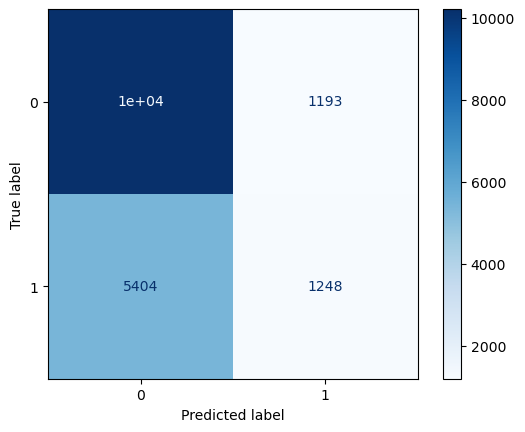

Model:  Nearest Neighbors
Accuracy: 0.87

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90     11400
           1       0.82      0.83      0.83      6652

    accuracy                           0.87     18052
   macro avg       0.86      0.86      0.86     18052
weighted avg       0.87      0.87      0.87     18052



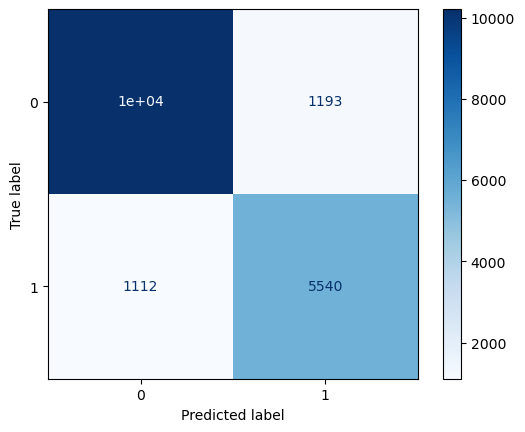

Model:  Decision Tree
Accuracy: 0.84

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88     11400
           1       0.79      0.79      0.79      6652

    accuracy                           0.84     18052
   macro avg       0.83      0.83      0.83     18052
weighted avg       0.84      0.84      0.84     18052



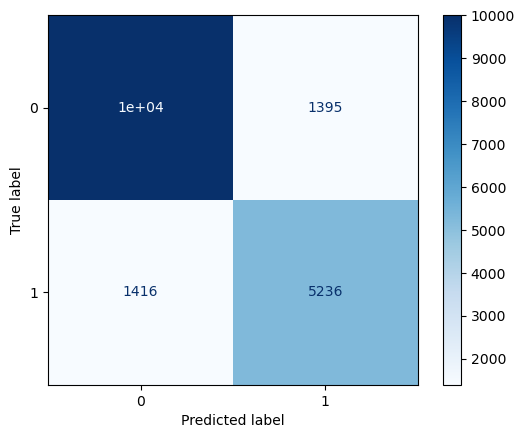

Model:  Random Forest
Accuracy: 0.88

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91     11400
           1       0.84      0.84      0.84      6652

    accuracy                           0.88     18052
   macro avg       0.87      0.88      0.88     18052
weighted avg       0.88      0.88      0.88     18052



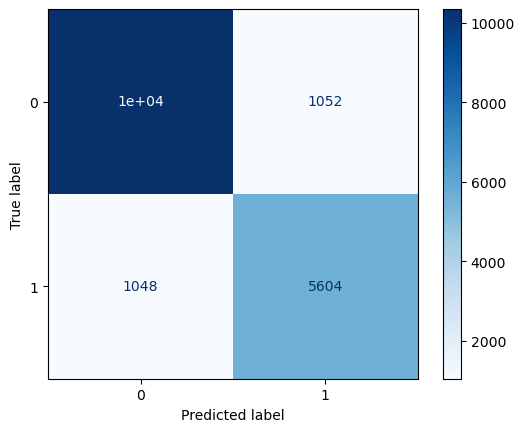

Model:  Neural Net
Accuracy: 0.89

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91     11400
           1       0.84      0.85      0.85      6652

    accuracy                           0.89     18052
   macro avg       0.88      0.88      0.88     18052
weighted avg       0.89      0.89      0.89     18052



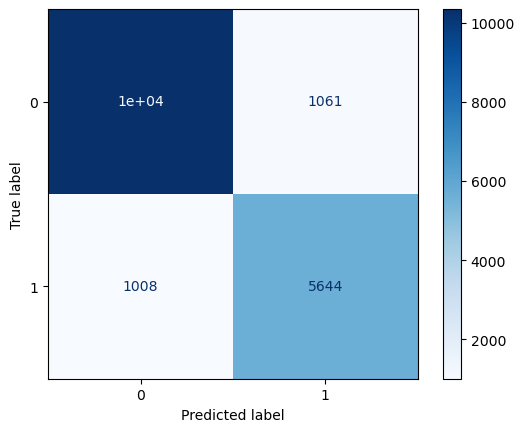

Model:  GradientBoosting
Accuracy: 0.88

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90     11400
           1       0.83      0.84      0.84      6652

    accuracy                           0.88     18052
   macro avg       0.87      0.87      0.87     18052
weighted avg       0.88      0.88      0.88     18052



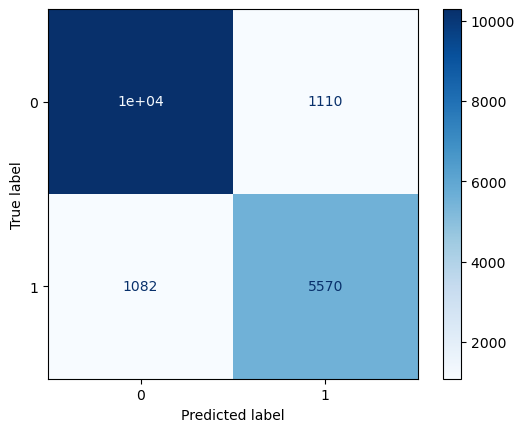

Model:  AdaBoost


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.85

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88     11400
           1       0.77      0.83      0.80      6652

    accuracy                           0.85     18052
   macro avg       0.83      0.84      0.84     18052
weighted avg       0.85      0.85      0.85     18052



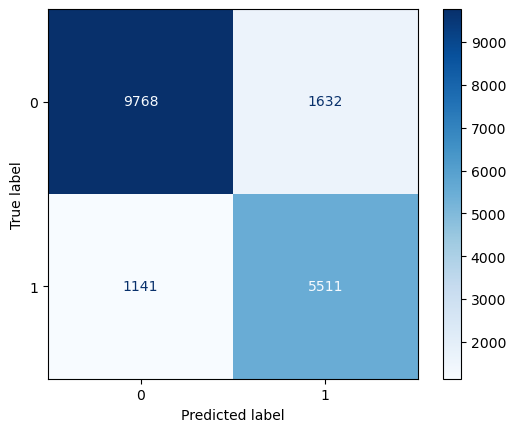

Model:  Naive Bayes
Accuracy: 0.80

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.78      0.83     11400
           1       0.69      0.85      0.76      6652

    accuracy                           0.80     18052
   macro avg       0.79      0.81      0.80     18052
weighted avg       0.82      0.80      0.81     18052



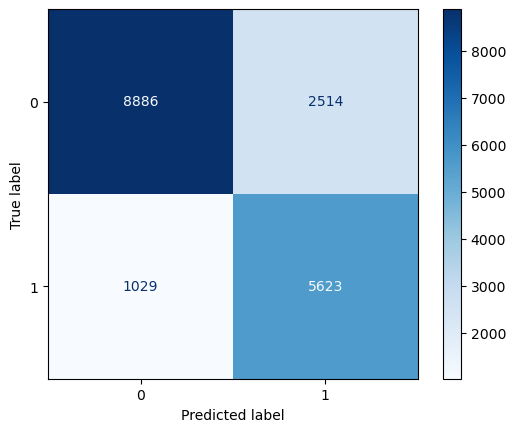

Model:  QDA
Accuracy: 0.76

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.71      0.79     11400
           1       0.63      0.84      0.72      6652

    accuracy                           0.76     18052
   macro avg       0.76      0.78      0.76     18052
weighted avg       0.79      0.76      0.76     18052



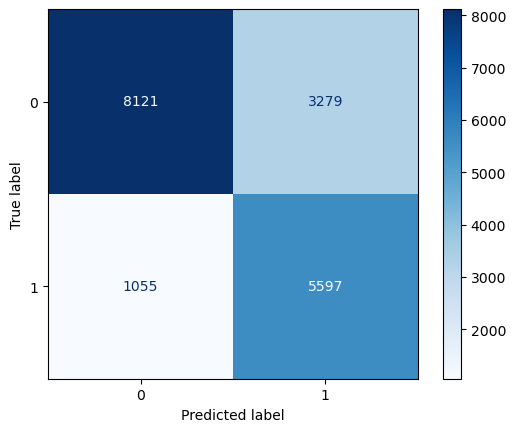

Model:  Ensemble Model


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.88

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91     11400
           1       0.83      0.84      0.84      6652

    accuracy                           0.88     18052
   macro avg       0.87      0.87      0.87     18052
weighted avg       0.88      0.88      0.88     18052



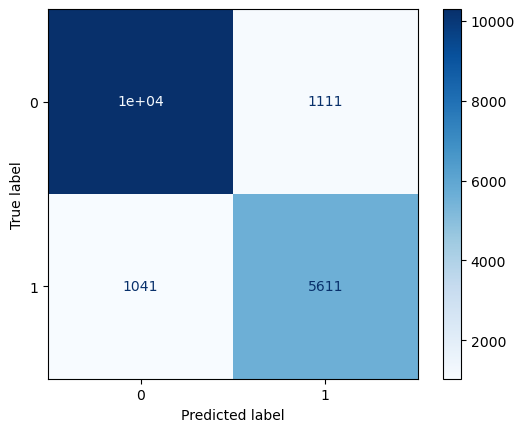

In [57]:
names = [
    "Logistic Regression", 
    "Nearest Neighbors",
    #"Linear SVM",
    #"RBF SVM",
    #"Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "GradientBoosting",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
    "Ensemble Model"
]

LR_clf=  LogisticRegression()
KN_clf=    KNeighborsClassifier()
DT_clf=    DecisionTreeClassifier()
Rf_clf=    RandomForestClassifier()
MLP_clf=    MLPClassifier(max_iter=5000, random_state=42)
GB_clf=    GradientBoostingClassifier()
AB_clf=    AdaBoostClassifier()
NB_clf=    GaussianNB()
QDA_clf=    QuadraticDiscriminantAnalysis()

# Step 4: Combine models using VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('LR', LR_clf),
    ('KN', KN_clf),
    ('DT', DT_clf),
    ('Rf', Rf_clf),
    ('MLP', MLP_clf),
    ('GB', GB_clf),
    ('AB', AB_clf),   
    ('NB', NB_clf),
    ('QDA', QDA_clf)
], voting='soft')  # 'hard' for majority voting, 'soft' for probability-based voting

classifiers = [
    LogisticRegression(), 
    KNeighborsClassifier(),
    #SVC(kernel="linear", C=0.025, random_state=42),
    #SVC(gamma=2, C=1, random_state=42),
    #GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(max_iter=5000, random_state=412),
    GradientBoostingClassifier(), 
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    voting_clf,
]

# iterate over classifiers
for name, clf in zip(names, classifiers):
    print("Model: ", name)

    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Evaluate the model's performance
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    
    # Classification report for precision, recall, f1-score
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    # Generate the confusion matrix
    
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix directly using scikit-learn's ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.show()


### Building and Training a Custom Neural Network

Instead of using the `MLP` model from the `sklearn` library, a custom neural network can be built and trained for greater flexibility.

- **Feature Normalization:** Prior to training, input features must be normalized. Here, we use `StandardScaler` from `sklearn` for this purpose.

- **Layer Normalization:** A technique to normalize inputs within each layer of the network, enhancing stability and improving the training process.

Epoch [10/100], Loss: 0.2597
Epoch [20/100], Loss: 0.2569
Epoch [30/100], Loss: 0.2545
Epoch [40/100], Loss: 0.2516
Epoch [50/100], Loss: 0.2504
Epoch [60/100], Loss: 0.2490
Epoch [70/100], Loss: 0.2497
Epoch [80/100], Loss: 0.2475
Epoch [90/100], Loss: 0.2475
Epoch [100/100], Loss: 0.2472


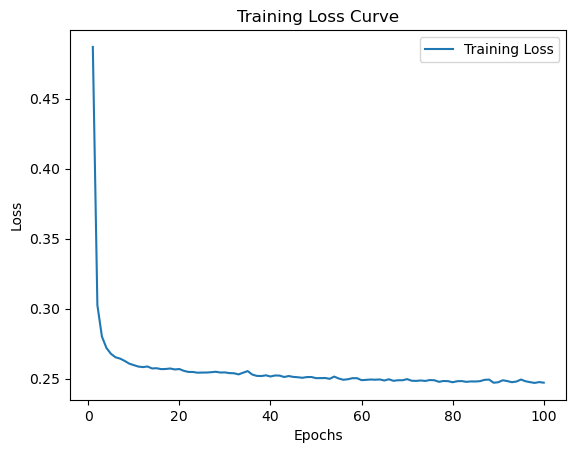

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Standardize the features (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for batching
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)

#  Define the neural network model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)   # First hidden layer
        self.ln1 = nn.LayerNorm(hidden_size1)            # Layer Normalization after the first layer
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)  # Second hidden layer
        self.ln2 = nn.LayerNorm(hidden_size2)             # Layer Normalization after the second layer
        
        self.relu = nn.ReLU()                            # Activation function
        self.fc3 = nn.Linear(hidden_size2, num_classes)   # Output layer

    def forward(self, x):
        out = self.fc1(x)
        out = self.ln1(out)  # Apply layer normalization after the first hidden layer
        out = self.relu(out)
        
        out = self.fc2(out)
        out = self.ln2(out)  # Apply layer normalization after the second hidden layer
        out = self.relu(out)
        
        out = self.fc3(out)
        return out

# Define model parameters
input_size = X_train.shape[1]  # Number of features
hidden_size1 = 16              # Number of neurons in the first hidden layer
hidden_size2 = 16              # Number of neurons in the second hidden layer
num_classes = len(set(y_train))  # Number of output classes 

# Instantiate the model
model = NeuralNet(input_size, hidden_size1, hidden_size2, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model and storing the loss at each epoch
num_epochs = 100
loss_values = []  # To store loss at each epoch

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()  # Accumulate loss

    epoch_loss = running_loss / len(train_loader)  # Average loss per epoch
    loss_values.append(epoch_loss)  # Store the loss for this epoch

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Step 6: Plot the training loss curve
plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

In [62]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)

    # Calculate accuracy
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'Accuracy on test set: {accuracy:.4f}')

Accuracy on test set: 0.8863


## Step 4: Use the Selected Trained Model to Predict the Probability of `is_airout`

In [64]:
df_test = pd.read_csv('data-test.csv')

df_input = df_test[input_features]


### Handling Missing Values in `hit_spin_rate`

In the test data, 307 entries have `NaN` values in the `hit_spin_rate` field, which is a float representing the ball's spin rate in rotations per minute (rpm) as it leaves the bat. These missing values can be filled with the average `hit_spin_rate` from the training dataset.

In [66]:
print(df_input.isna().sum())

# use the training data set average value
display(df_cleaned.describe()['hit_spin_rate'])

mean_hit_spin_rate = df_cleaned.describe()['hit_spin_rate'].loc['mean']
print(mean_hit_spin_rate)
df_input.fillna({'hit_spin_rate': mean_hit_spin_rate}, inplace=True)

horz_exit_angle      0
hit_spin_rate      307
vert_exit_angle      0
exit_speed           0
dtype: int64


count    90256.000000
mean      2902.835021
std       1292.091305
min          0.705892
25%       1909.882029
50%       2809.674805
75%       3831.284461
max       7994.340000
Name: hit_spin_rate, dtype: float64

2902.835021462507


/var/folders/1s/2gfv98317bnc5_7xb_2604sc0000gp/T/ipykernel_63586/3677833392.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna({'hit_spin_rate': mean_hit_spin_rate}, inplace=True)


### Train the Optimal Model on the Entire Training Dataset Before Making Predictions on the Test Set

In [68]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=5000, learning_rate='adaptive', learning_rate_init=0.003, random_state=412)
mlp_clf= make_pipeline(StandardScaler(), mlp_clf)

mlp_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(256, 128),
                               learning_rate='adaptive',
                               learning_rate_init=0.003, max_iter=5000,
                               random_state=412))])

In [69]:
select_model =  mlp_clf #Rf_clf

#select_model.fit(X, y)

### Output the Predicted Probabilities for Both Classes: `is_airout` (No/Yes)

In [71]:
y_prob_pred = select_model.predict_proba(df_input)
y_prob_pred

array([[9.15410793e-01, 8.45892070e-02],
       [1.89507679e-02, 9.81049232e-01],
       [9.59767878e-01, 4.02321221e-02],
       ...,
       [9.99981698e-01, 1.83024179e-05],
       [9.92748435e-01, 7.25156531e-03],
       [9.22707771e-01, 7.72922293e-02]])

In [72]:
output_df  = df_test.copy()
output_df['p_airout'] = y_prob_pred[:, 1]

In [73]:
output_df.to_csv('data-test-submission1.csv', index=False)